In [1]:
# Jupter notebook magic
%matplotlib inline

# Import libraries to work with the data
import os
import sys
sys.path.append(r'C:\work\src\HiMAT\GRACE\GRACE')

from branca.colormap import linear
import folium

import geopandas as gpd
from geopandas import GeoDataFrame

import h5py
import numpy as np
import pandas as pd
import pyepsg
import scipy.optimize
from shapely.geometry import (Polygon, Point, box)

from GRACE import (extract_grace, get_mascon_gdf, get_cmwe_trend_analysis)

In [2]:
fname = 'C:\work\datadrive\GRACE\GSFC.glb.200301_201607_v02.3b-ICE6G.h5'

In [3]:
fpath = os.path.join(os.path.abspath(os.path.curdir), fname)

In [4]:
f = extract_grace(fpath)

Data extracted: 
---
Group: mascon
---
<HDF5 dataset "area_deg": shape (1, 41168), type "<f8">
<HDF5 dataset "area_km2": shape (1, 41168), type "<f8">
<HDF5 dataset "basin": shape (1, 41168), type "<f8">
<HDF5 dataset "elev_flag": shape (1, 41168), type "<f8">
<HDF5 dataset "lat_center": shape (1, 41168), type "<f8">
<HDF5 dataset "lat_span": shape (1, 41168), type "<f8">
<HDF5 dataset "location": shape (1, 41168), type "<f8">
<HDF5 dataset "lon_center": shape (1, 41168), type "<f8">
<HDF5 dataset "lon_span": shape (1, 41168), type "<f8">
---
Group: size
---
<HDF5 dataset "N_arcs": shape (1, 1), type "<f8">
<HDF5 dataset "N_mascon_times": shape (1, 1), type "<f8">
<HDF5 dataset "N_mascons": shape (1, 1), type "<f8">
---
Group: solution
---
<HDF5 dataset "cmwe": shape (41168, 148), type "<f8">
<HDF5 dataset "uncertainty": shape (41168, 148), type "<f8">
---
Group: time
---
<HDF5 dataset "list_ref_days_solution": shape (1, 4128), type "<f8">
<HDF5 dataset "n_ref_days_solution": shape (1,

In [5]:
mascon = f['mascon']

In [6]:
mascon_gdf = get_mascon_gdf(mascon)

There are 41168 Mascons in this dataset.


## read in the natural Earth dataset

In [17]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

## build a polygon representing HMA bounding box

In [9]:
coordinates = [(62,26), (62,46), (106,46), (106, 26)]
# Create a Shapely polygon from the coordinate-tuple list
poly = Polygon(coordinates)
# create a geodataframe
HMA_region = gpd.GeoDataFrame()
HMA_region.loc[0, 'geometry'] = poly

C:\work\src\HiMAT\GRACE\GRACE\GRACE.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  mascon_gdf['avg_mass_change_cm'] = avg_mass


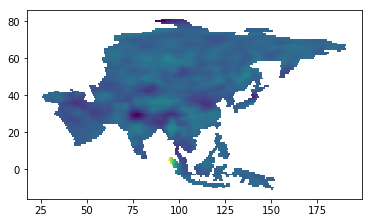

In [11]:
# HMA
HMA = mascon_gdf[(mascon_gdf['location'] == 80.0) & ((mascon_gdf['basin'] > 5000.0) & (mascon_gdf['basin'] < 6100.0))]
HMA_w_trend = get_cmwe_trend_analysis(HMA, f)
HMA_w_trend.plot(column='avg_mass_change_cm')

In [13]:
gpd_intersect = gpd.overlay(HMA_region, HMA_w_trend, how='intersection')

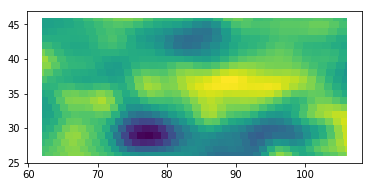

In [15]:
gpd_intersect.plot(column='avg_mass_change_cm')

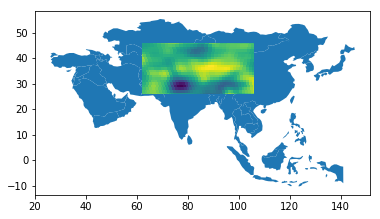

In [16]:
gpd_intersect.plot(column='avg_mass_change_cm', ax=world[world['continent'] == 'Asia'].plot(), figsize=(10, 10));